## Instructions:

- For questions that require coding, you need to write the relevant code and display its output. Your output should either be the direct answer to the question or clearly display the answer in it.
- For questions that require a written answer (sometimes along with the code), you need to put your answer in a Markdown cell. Writing the answer as a comment or as a print line is not acceptable.
- Receiving help from classmates and/or ideas from Generative AI is allowed. **However, you must submit your own original work.** 
- You need to render this file as HTML using Quarto and submit the HTML file. **Please note that this is a requirement and not optional.** A submission cannot be graded until it is properly rendered.

Proper formatting: **5 points**
- Quarto rendering **(2 points)** (If the file is rendered wrong, the correct version needs to be submitted first to be eligible for grading; 2 points will be deducted afterwards.)
- No unnecessary/redundant/commented-out code chunk, text or output. **(2 points)**
- Written answers in Markdown cells, not added as a comment or a print line. **(1 points)**

Import all the libraries and tools you need below.

In [28]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, InputLayer, Embedding, Dropout, SimpleRNN, LSTM, GRU, Conv1D, MaxPooling1D,Conv2D, MaxPooling2D, Flatten, Input, BatchNormalization, MaxPool2D
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import CategoricalCrossentropy, MeanSquaredError
from tensorflow.keras.preprocessing.sequence import pad_sequences

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score, ConfusionMatrixDisplay, confusion_matrix

## 1) CNN for Image Classification (30 points)

**Before you start:** This dataset and its classification is a popular problem on Kaggle, so you can find assistance there on both the network architecture and the image generators. This is fine, since one of the main goals of this question is to get you familiar with using big data. **There is only one restriction: You are not permitted to use any built-in network models (VGG16, ResNet etc.) or transfer learning. You must build your own architecture from scratch and train it for credit.**

In this question, you will use a Convolutional Neural Network (CNN) to predict if the patient has pneumonia (1) or not (0) using their chest x-ray images. The image dataset for this task is too big to read in the memory of any Python environment, so it needs to be read and fed into the network in chunks. To implement this, you will need [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) objects.

Download the [chest_xray](https://nuwildcat-my.sharepoint.com/:f:/g/personal/ebf987_ads_northwestern_edu/EhIXaZ7hTNdEiv67m2mM51MBx5eLC0fJiMoO9SCWZCSdHQ?e=iOEIFp) folder and put it in the same directory as this ipynb file. You will use the paths given below as input to the generators you will create, which will in turn be the network inputs for the data.

In [2]:
train_path = 'chest_xray/train'
val_path = 'chest_xray/val'
test_path = 'chest_xray/test'

### a)

Create two generator objects: 

- The first object is for the training data and it will include the proper inputs for data augmentation, so that the network can train better with more data. Data augmentation in this question's context means increasing the training data size with certain image processing tools. The most common data augmentation tools for images are zooming and shearing different parts of each image and using these parts as different training images. Include the following:
    - A `rescale` ratio of 1/255.0
    - A `shear_range` of 0.2
    - A `zoom_range` of 0.2
- The second object is for the validation and test data, so it will not include any data augmentation input. It will include only the same `rescale` ratio as the training generator object.

**(5 points)**

In [3]:
generator1 = ImageDataGenerator(rescale=1/255.0, shear_range=0.2, zoom_range=0.2)
generator2 = ImageDataGenerator(rescale=1/255.0)

### b)

Using the generator objects created in Part a and their `.flow_from_directory` method, create three generators for training, validation and test data. Note the following:

- The training generator should be created with the first generator object. The validation and test generators should be created with the second generator object.
- In all generators, use the proper path. The `target_size` and `batch_size` is up to you. You may need to experiment with them depending on the model performance.
- Keep in mind that the images are `grayscale`.
- You can use the categorical or binary `class_mode` but either way, you adjust the output layer of the network and the cost function accordingly.

**(5 points)**

In [7]:
training_generator = generator1.flow_from_directory(
    directory=train_path, target_size=(128, 128), batch_size=64, color_mode='grayscale', class_mode='binary')
validation_generator = generator2.flow_from_directory(
    directory=val_path, target_size=(128, 128), batch_size=64, color_mode='grayscale', class_mode='binary')
test_generator = generator2.flow_from_directory(
    directory=test_path, target_size=(128, 128), batch_size=64, color_mode='grayscale', class_mode='binary')

Found 5214 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


### c)

Train and tune a CNN for the binary classification task. Note the following:

- Instead of the two inputs for the training and the test data each, you only need to use the training and the test generators created in Part b.
- Instead of `validation_split`, you need to use `validation_data` and the validation generator created in Part b.
- To calculate the test accuracy, you need to (1) set the `metrics` input in `.compile` to accuracy and (2) use the `.evaluate` method of the trained network object with the test generator to return the test loss and the test accuracy, respectively.
- The architecture, amount of regularization, optimizer and every other aspect of the network is entirely up to you.
- Keep in mind that there are many aspects that are already determined by the data, the prediction task and common practices.
- After the training, **print the test accuracy**.
- **Visualize the training and the validation loss throughout all epochs**. (It is fine if the validation loss indicates some overfitting as long as you exceed the required thresholds.)
- Your network should return **a test accuracy above 90%**. (The validation data is too small for reliable results.)

**Please also note that this question requires a CNN. Any ANN architecture will not receive any credit.**

**(20 points)**

In [8]:
cnn_xray = Sequential()

# Simplified initial layers
cnn_xray.add(Conv2D(16, (3,3), strides=1, padding='same', activation='relu', input_shape=(128,128,1)))
cnn_xray.add(BatchNormalization())
cnn_xray.add(MaxPool2D((2,2), strides=2, padding='same'))

# Reduced number of layers and filters
cnn_xray.add(Conv2D(32, (3,3), strides=1, padding='same', activation='relu'))
cnn_xray.add(Dropout(0.1))
cnn_xray.add(BatchNormalization())
cnn_xray.add(MaxPool2D((2,2), strides=2, padding='same'))

# Only one additional Conv layer
cnn_xray.add(Conv2D(64, (3,3), strides=1, padding='same', activation='relu'))
cnn_xray.add(Dropout(0.2))
cnn_xray.add(BatchNormalization())
cnn_xray.add(MaxPool2D((2,2), strides=2, padding='same'))

# Flatten and dense layers
cnn_xray.add(Flatten())
cnn_xray.add(Dense(units=32, activation='relu'))  # Further reduced units
cnn_xray.add(Dropout(0.2))
cnn_xray.add(Dense(units=1, activation='sigmoid'))

cnn_xray.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128, 128, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │       524,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 548,097 (2.09 MB)

 Trainable params: 547,873 (2.09 MB)

 Non-trainable params: 224 (896.00 B)

In [9]:
cnn_xray.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = cnn_xray.fit(training_generator, epochs=10, validation_data=validation_generator, callbacks=[early_stopping])

Epoch 1/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.7805 - loss: 1.1672 - val_accuracy: 0.5000 - val_loss: 3.3097
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.9320 - loss: 0.2012 - val_accuracy: 0.5000 - val_loss: 10.2707
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.9406 - loss: 0.1727 - val_accuracy: 0.5000 - val_loss: 12.7461
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.9405 - loss: 0.1640 - val_accuracy: 0.5000 - val_loss: 9.9524
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.9484 - loss: 0.1415 - val_accuracy: 0.5000 - val_loss: 9.6247
Epoch 6/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.9528 - loss: 0.1369 - val_accuracy: 0.5000 - val_loss: 2.4680
Epoch 7/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.9458 - loss: 0.1404 - val_accuracy: 0.5000 - val_loss: 6.3717
Epoch 8/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.9511 - loss: 0.1454 - val_accuracy: 0.6250 -

c:\Users\13138\anaconda3\envs\stat362\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.8928 - loss: 0.4113

Test accuracy: 90.38%


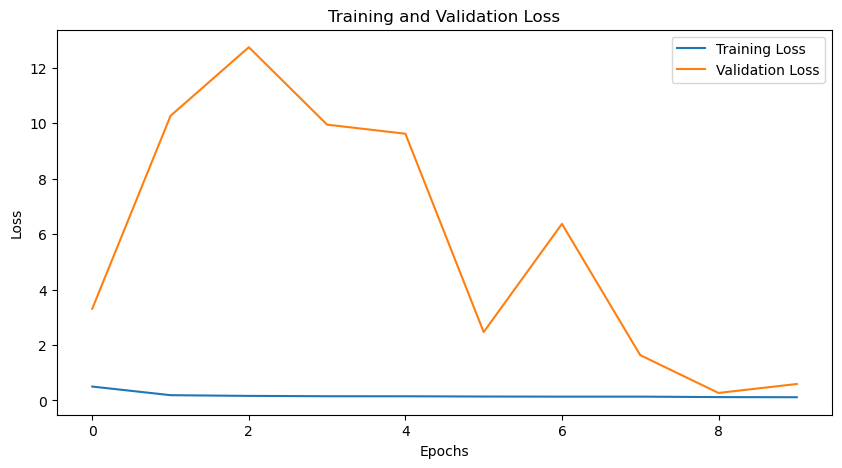

In [10]:
# Evaluation
test_loss, test_acc = cnn_xray.evaluate(test_generator)
print(f'\nTest accuracy: {test_acc*100:.2f}%')

# Visualization
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 2) CNN for Sequence Classification (25 points)

In this question, you will use a CNN to classify the patients with different types of cardiac arrhythmia (or without any cardiac arrhythmia) using their electrocardiograms (EKGs).

### a)


Read the data from **heartbeat.csv**. Note that this is the same data that you used with an ANN in the previous homework assignment. Preprocess the data:

- Create the predictors and the response/target value.
- Create the training and the test datasets with a **stratified** 90%-10% split. Use `random_state=1`.
- One-hot-encode the training classes.

Note that since all the predictor values are already normalized, you do not need to scale the datasets.

**(1 point)**

In [19]:
heart_data = pd.read_csv('heartbeat.csv')

X = heart_data.iloc[:, 0:187]
y = heart_data.iloc[:, 187]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, stratify=y, random_state=1)

# ohe
y_train = to_categorical(y_train, num_classes=5)
y_test = to_categorical(y_test, num_classes=5)

### b)

Note that even though the observations are not images, they do have a one-dimensional temporal structure, which can be used as additional information by a CNN. To use each EKG signal as a "one dimensional image," you need to add a third dimension (which will be the number of channels) to both the training and the test datasets.

Since the signal is coming from one single source (or a single lead, in cardiology terms) the number of channels should be 1.

Reshape the training and the test datasets. Both should have their dimensions as: (`number of observations, number of time points, number of channels`).

**(4 points)**

In [20]:
X_train = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)

print("X_train shape:", X_train.shape) 
print("X_test shape:", X_test.shape)

X_train shape: (20774, 187, 1)
X_test shape: (2309, 187, 1)


### c)

Train and tune an CNN for the 5-class classification task. Note the following:

- Use a **validation split of 0.1**. This is for comparison purposes with the required threshold.
- The architecture, amount of regularization, optimizer and every other aspect of the network is entirely up to you.
- Keep in mind that there are many aspects that are already determined by the data, the prediction task and common practices.
- After the training, **print the test accuracy and the test confusion matrix**.
- **Visualize the training and the validation loss throughout all epochs**. (It is fine if the validation loss indicates some overfitting as long as you exceed the required thresholds.)
- Your network should return **both a validation accuracy and a test accuracy above 95%**. You are expected to know how to monitor a validation metric while training a network.
- The "images" here are one-dimensional, which means that the only dimensions you can communicate to the network are the **number of time points and the number of channels**. You need to set the input **shape** accordingly. Also, `Conv2D` and `MaxPooling2D` layers will not work anymore; you need their **one-dimensional counterparts**. (Explore the Keras documentation.)

**Please also note that this question requires a CNN. Any ANN architecture will not receive any credit.**

**(20 points)**

In [35]:
# Define the 1D cnn_heart model
cnn_heart = Sequential()

# Input layer
cnn_heart.add(InputLayer(shape=(187, 1)))  # 187 time points, 1 channel

# Conv1D layers
cnn_heart.add(Conv1D(32, kernel_size=3, activation='relu'))
cnn_heart.add(Conv1D(64, kernel_size=3, activation='relu'))
cnn_heart.add(MaxPooling1D(pool_size=2))

cnn_heart.add(Conv1D(64, kernel_size=3, activation='relu'))
cnn_heart.add(Conv1D(128, kernel_size=3, activation='relu'))
cnn_heart.add(MaxPooling1D(pool_size=2))

# Flatten and dense layers
cnn_heart.add(Flatten())
cnn_heart.add(Dense(500, activation='relu'))
cnn_heart.add(Dropout(0.3))
cnn_heart.add(Dense(100, activation='relu'))
cnn_heart.add(Dropout(0.3))
cnn_heart.add(Dense(50, activation='relu'))
cnn_heart.add(Dropout(0.3))

# Output layer for 5-class classification
cnn_heart.add(Dense(5, activation='softmax'))

# Model summary
cnn_heart.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_12 (Conv1D)              │ (None, 185, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 183, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 91, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 89, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 87, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 43, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 5504)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 500)            │     2,752,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 100)            │        50,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 5)              │           255 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,851,297 (10.88 MB)

 Trainable params: 2,851,297 (10.88 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Compile the model
cnn_heart.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)

# Train the cnn_heart
history = cnn_heart.fit( X_train, y_train, epochs=50, batch_size=64, validation_split=0.1, callbacks=[early_stopping, reduce_lr], verbose=1)


Epoch 1/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 25s 78ms/step - accuracy: 0.6247 - loss: 0.9402 - val_accuracy: 0.8922 - val_loss: 0.2915 - learning_rate: 0.0010
Epoch 2/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 24s 83ms/step - accuracy: 0.8943 - loss: 0.3194 - val_accuracy: 0.9244 - val_loss: 0.2150 - learning_rate: 0.0010
Epoch 3/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 23s 79ms/step - accuracy: 0.9280 - loss: 0.2286 - val_accuracy: 0.9374 - val_loss: 0.1767 - learning_rate: 0.0010
Epoch 4/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 23s 79ms/step - accuracy: 0.9401 - loss: 0.1872 - val_accuracy: 0.9408 - val_loss: 0.1815 - learning_rate: 0.0010
Epoch 5/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 24s 83ms/step - accuracy: 0.9529 - loss: 0.1461 - val_accuracy: 0.9456 - val_loss: 0.1625 - learning_rate: 0.0010
Epoch 6/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 24s 81ms/step - accuracy: 0.9599 - loss: 0.1235 - val_accuracy: 0.9528 - val_loss: 0.1476 - learning_rate: 0.0010
Epoch 7/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 25s 84ms/step - accuracy: 0.9673 - l

Test Accuracy: 95.71%
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


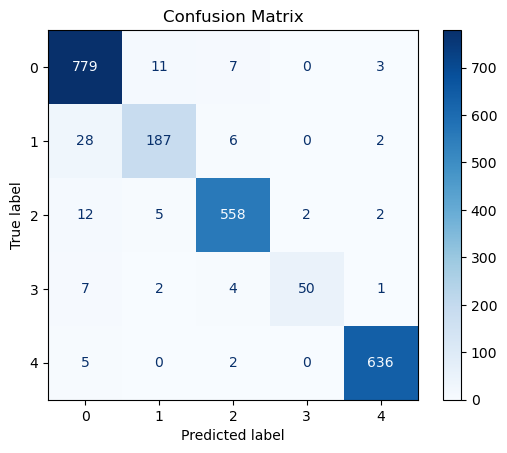

In [29]:
test_loss, test_accuracy = cnn_heart.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

y_pred = cnn_heart.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

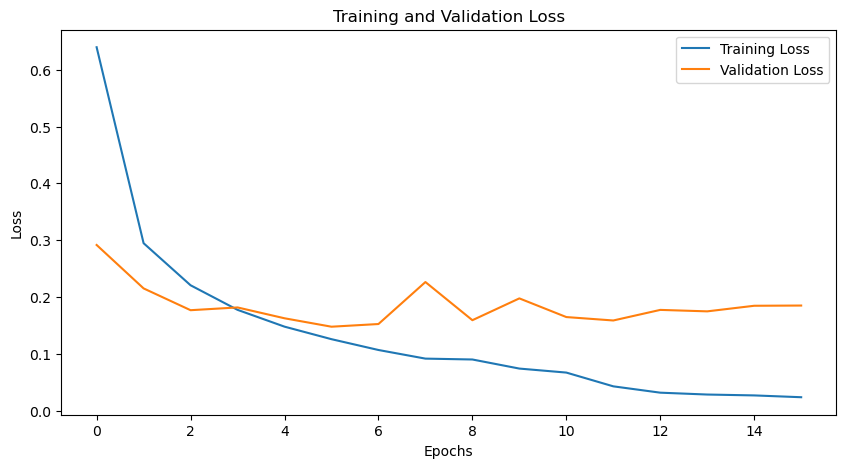

In [30]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 3) RNN for Sequence Classification (28 points)

In this question, you will use a Recurrent Neural Network (RNN) or its extensions to classify hand gestures using the electromyogram (EMG) signals taken from the hand muscles. EMG signals represent the neuromuscular activity in voltage.

### a)

Read the data from **hand_gestures.csv**. Each observation is a hand gesture. All the columns, except the last one, are the voltage values of the EMG signal and will be the predictors for the classification task. The last column has the class values: 0 for rock, 1 for scissors, 2 for paper, 3 for "okay".

Preprocess the data:

- Create the predictors and the response/target value.
- Create the training and the test datasets with a **stratified** 80%-20% split. Use `random_state=1`.
- Scale the training and the test datasets.
- One-hot-encode the training classes.

**(1 point)**

In [32]:
hand_data = pd.read_csv('hand_gestures.csv')
X = hand_data.iloc[:, :-1]
y = hand_data.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) 
X_test = scaler.transform(X_test)

y_train = to_categorical(y_train, num_classes=4) 
y_test = to_categorical(y_test, num_classes=4) 

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (9342, 64)
X_test shape: (2336, 64)
y_train shape: (9342, 4)
y_test shape: (2336, 4)


### b)

Note that each observation is 64-dimensional. These 64 values represent **8 concatenated sequences that are each 8 time points long**. Each sequence comes from a sensor located on a different part of the wrist, so the time-series data is 8-dimensional.

Reshape the training and the test data such that each observation is an 8-dimensional sequence with 8 time points.

**(4 points)**

In [33]:
X_train_reshaped = X_train.reshape(X_train.shape[0], 8, 8)
X_test_reshaped = X_test.reshape(X_test.shape[0], 8, 8)

print("X_train_reshaped shape:", X_train_reshaped.shape)
print("X_test_reshaped shape:", X_test_reshaped.shape)

X_train_reshaped shape: (9342, 8, 8)
X_test_reshaped shape: (2336, 8, 8)


### c)

Create an RNN for the 4-class classification task. Note the following:

- Use a **validation split of 0.1**. This is for comparison purposes with the required threshold.
- The architecture, amount of regularization, optimizer and every other aspect of the network is entirely up to you.
- Keep in mind that there are many aspects that are already determined by the data, the prediction task and common practices.
- After the training, **print the test accuracy and the test confusion matrix**.
- **Visualize the training and the validation loss throughout all epochs**. (It is fine if the validation loss indicates some overfitting as long as you exceed the required thresholds.)
- Your network should return **both a validation accuracy and a test accuracy above 97%**. You are expected to know how to monitor a validation metric while training a network.
- You have the option to use the extensions of an RNN, such as Long Short Term Memory (LSTM) or Gated Recurrent Unit (GRU).

**Please also note that this question requires an RNN or its extensions. Any ANN or CNN architectures will not receive any credit.**

**(20 points)**

In [36]:
rnn_gesture = Sequential()

rnn_gesture.add(InputLayer(shape=(8, 8)))

rnn_gesture.add(GRU(128, return_sequences=True)) 
rnn_gesture.add(BatchNormalization())
rnn_gesture.add(Dropout(0.3))

rnn_gesture.add(GRU(64, return_sequences=False))  
rnn_gesture.add(BatchNormalization())
rnn_gesture.add(Dropout(0.3))

rnn_gesture.add(Dense(64, activation='relu'))
rnn_gesture.add(Dropout(0.3))

rnn_gesture.add(Dense(4, activation='softmax'))

rnn_gesture.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 8, 128)         │        52,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 8, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 8, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95,428 (372.77 KB)

 Trainable params: 95,044 (371.27 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.5530 - loss: 1.1057 - val_accuracy: 0.8032 - val_loss: 0.7101 - learning_rate: 0.0010
Epoch 2/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9135 - loss: 0.2657 - val_accuracy: 0.9390 - val_loss: 0.2756 - learning_rate: 0.0010
Epoch 3/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9427 - loss: 0.1768 - val_accuracy: 0.9626 - val_loss: 0.1305 - learning_rate: 0.0010
Epoch 4/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9588 - loss: 0.1345 - val_accuracy: 0.9701 - val_loss: 0.0856 - learning_rate: 0.0010
Epoch 5/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9659 - loss: 0.1169 - val_accuracy: 0.9701 - val_loss: 0.0810 - learning_rate: 0.0010
Epoch 6/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9634 - loss: 0.1060 - val_accuracy: 0.9690 - val_loss: 0.0731 - learning_rate: 0.0010
Epoch 7/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9702 - loss: 0.

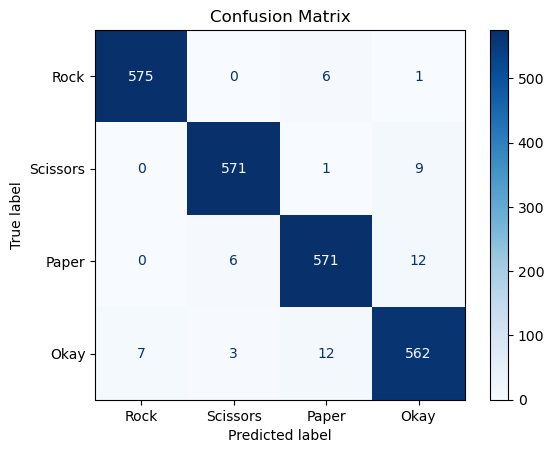

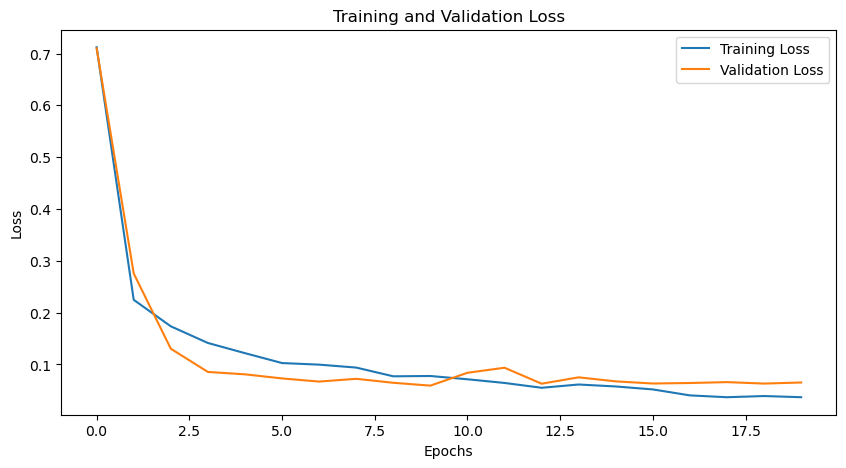

In [42]:
rnn_gesture.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)

history = rnn_gesture.fit(
    X_train_reshaped, y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

test_loss, test_accuracy = rnn_gesture.evaluate(X_test_reshaped, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

y_pred = rnn_gesture.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Rock", "Scissors", "Paper", "Okay"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### d)

What is the number of **total** hidden layers in your architecture if you unravel your network through time? Note that the answer entirely depends on your architecture. **(3 points)** 

When the RNN is unfolded over time, the first GRU layer processes 8 time steps, each with a GRU cell, BatchNormalization, and Dropout, totaling 24 layers. The second GRU layer adds 3 layers, and the dense layers add 2 more. In total, there are 29 hidden layers.

## 4) Momentum, RMSProp and Adam (12 points)

In this question, you will extend the Gradient Descent algorithm you implemented in Homework Assignment 1 to its versions used for neural networks.

Copy the `calc_cost_gradient` function you wrote in Homework Assignment 1 below, along with any helper function (such as `sigmoid`) that you used in it.

In [44]:
#| echo: false

# The YAML setting above will hide this cell in the HTML file for visual purposes. 
# Put all your code from Homework Assignment 1 here.

def sigmoid(value):
    sig_value = 1/(1+np.exp(-value))
    return sig_value

def calc_cost_gradient(model_params, X_train, y_train):
    if  isinstance(X_train, pd.DataFrame):
        X_train.insert(0, 'intercept', 1)
    else:
        X_train = np.insert(X_train, 0, 1, axis=1)
    z = np.dot(X_train, model_params)
    probas = sigmoid(z)
    cost = (-1 / X_train.shape[0]) * (np.sum(y_train*np.log(probas) + (1-y_train)*np.log(1-probas)))
    gradient = -1 / X_train.shape[0] * np.dot(np.transpose(X_train), (y_train-probas))
    return cost, gradient

Define a function called `GradientDescent_with_Extensions`. It should be similar to the `GradientDescent` function written for Homework Assignment 1, with some important differences:

- It should take four more inputs: `beta1`, `beta2`, `eps` and `extension`.
- All four of these inputs should be `None` (or 'none', depending on your version) by default.
- If `extension` is `None`, the function should implement pure gradient descent.
- If `extension` is `momentum`, it should implement the Momentum algorithm with `beta1` as the factor for the running exponential average.
- If `extension` is `rmsprop`, it should implement the RMSProp algorithm with `beta2` as the factor for the running exponential average and `eps` as the term that avoids dividing by zero.
- If `extension` is `adam`, it should implement the Adam algorithm with `beta1`, `beta2` and `eps` involved properly.

**Note:** To check if your implementation is working (and converging), you can run it with the data you used in Homework Assignment 1, but displaying that in this notebook is not mandatory.

In [48]:
def GradientDescent_with_Extensions(X_train, y_train, learning_rate=0.01, num_iterations=1000, beta1=None, beta2=None, eps=None, extension=None):
    if isinstance(X_train, pd.DataFrame):
        X_train.insert(0, 'intercept', 1)
    else:
        X_train = np.insert(X_train, 0, 1, axis=1)
    
    model_params = np.zeros(X_train.shape[1])
    cost_history = []
    
    # initialize vars for momentum, rmsprop, and adam
    v = np.zeros_like(model_params)  # momentum
    s = np.zeros_like(model_params)  # rmsprop
    t = 0  # adam time step
    
    for i in range(num_iterations):
        cost, gradient = calc_cost_gradient(model_params, X_train, y_train)
        cost_history.append(cost)
        
        if extension is None:
            # normal gradient descent
            model_params -= learning_rate * gradient
        elif extension == 'momentum':
            # momentum update
            v = beta1 * v + (1 - beta1) * gradient
            model_params -= learning_rate * v
        elif extension == 'rmsprop':
            # rmsprop update
            s = beta2 * s + (1 - beta2) * (gradient ** 2)
            model_params -= learning_rate * gradient / (np.sqrt(s) + eps)
        elif extension == 'adam':
            # adam update
            t += 1
            v = beta1 * v + (1 - beta1) * gradient
            s = beta2 * s + (1 - beta2) * (gradient ** 2)
            v_hat = v / (1 - beta1 ** t)
            s_hat = s / (1 - beta2 ** t)
            model_params -= learning_rate * v_hat / (np.sqrt(s_hat) + eps)
    
    return model_params, cost_history